### Hazardous Asteroid Prediction Analysis via Random Forest Classifier:

### 1.Feature Selection from the Dataset

This dataset contains information about **Near-Earth Objects (NEOs)** observed between **1910–2024**. Our objective is to identify the most important features for predicting the **asteroid hazard status** (`is_hazardous`).

Below is a brief description and analysis of each feature in the dataset:

| Feature Name              | Description                                                                                      | Usefulness for Prediction |
|---------------------------|--------------------------------------------------------------------------------------------------|----------------------------|
| `neo_id`                 | Unique identifier for each near-earth object.                                                    |  Not useful              |
| `name`                   | Name or designation of the discovered asteroid. May be a proper name or a catalog number.        |  Not useful              |
| `absolute_magnitude`     | Measures the asteroid’s intrinsic brightness. Lower values mean brighter (and often larger) objects. Typically ranges from 10 (very bright) to 30 (very faint/small). |  Useful (size indicator) |
| `estimated_diameter_min` | Minimum estimated diameter in kilometers.                                                        |  Useful                  |
| `estimated_diameter_max` | Maximum estimated diameter in kilometers.                                                        |  Useful                  |
| `orbiting_body`          | The planet the object is orbiting. In this dataset, all are orbiting Earth.                      |  Not useful              |
| `relative_velocity`      | Velocity relative to Earth, measured in km/h.                                                    |  Useful                  |
| `miss_distance`          | Distance at closest approach to Earth, measured in kilometers.                                   |  Useful                  |
| `is_hazardous`           | **Target variable** — Boolean value indicating whether the object is classified as potentially hazardous. (`True`/`False`) |  Target Variable        |

>  **Selected Features for Modeling**:
- `absolute_magnitude`
- `estimated_diameter_min`
- `estimated_diameter_max`
- `relative_velocity`
- `miss_distance`

>  **Dropped Features**:
- `neo_id`, `name`, `orbiting_body`



### Installing the dependencies:

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.pipeline import make_pipeline

### 2. Covariance and Correlation analysis:
Here we calculate the covariance and correlation among these features.

Covariance Matrix:
                        absolute_magnitude  estimated_diameter_min  \
absolute_magnitude            8.475181e+00               -0.543380   
estimated_diameter_min       -5.433800e-01                0.098524   
estimated_diameter_max       -1.215035e+00                0.220306   
relative_velocity            -2.655905e+04             1843.205823   
miss_distance                -1.291344e+07           726890.973396   
is_hazardous                 -3.341646e-01                0.017265   

                        estimated_diameter_max  relative_velocity  \
absolute_magnitude               -1.215035e+00      -2.655905e+04   
estimated_diameter_min            2.203061e-01       1.843206e+03   
estimated_diameter_max            4.926194e-01       4.121534e+03   
relative_velocity                 4.121534e+03       6.969198e+08   
miss_distance                     1.625378e+06       1.769124e+11   
is_hazardous                      3.860601e-02       1.647399e+03   

      

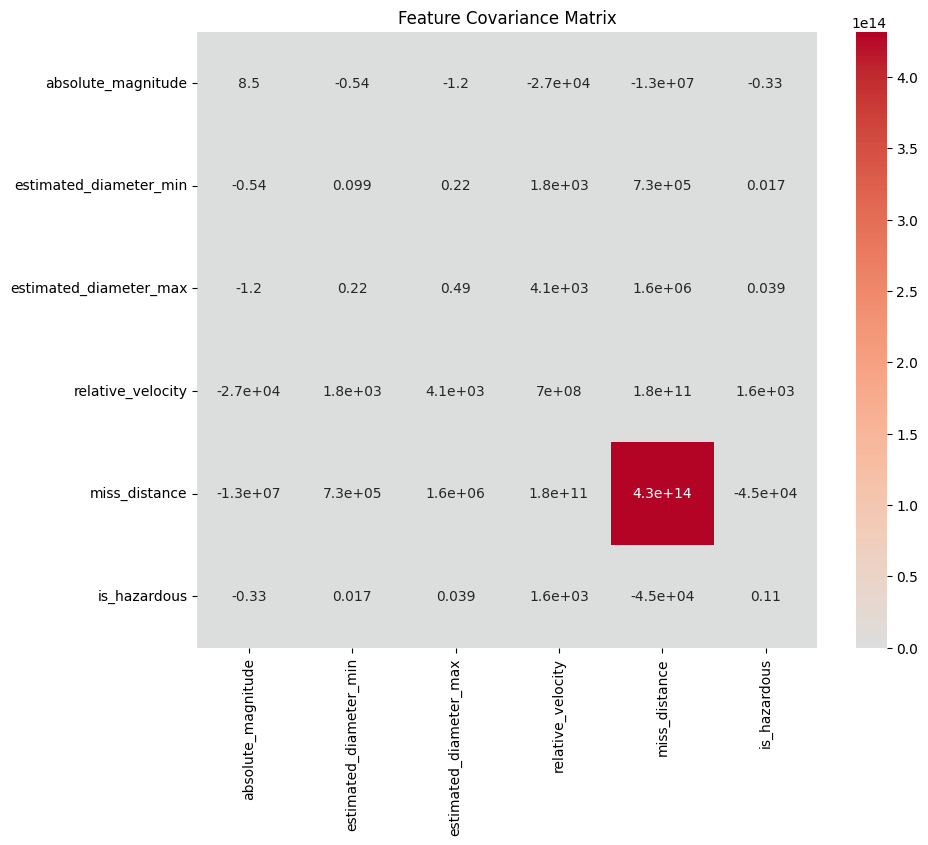


Correlation Matrix:
                        absolute_magnitude  estimated_diameter_min  \
absolute_magnitude                1.000000               -0.594646   
estimated_diameter_min           -0.594646                1.000000   
estimated_diameter_max           -0.594646                1.000000   
relative_velocity                -0.345570                0.222434   
miss_distance                    -0.213523                0.111475   
is_hazardous                     -0.343996                0.164841   

                        estimated_diameter_max  relative_velocity  \
absolute_magnitude                   -0.594646          -0.345570   
estimated_diameter_min                1.000000           0.222434   
estimated_diameter_max                1.000000           0.222434   
relative_velocity                     0.222434           1.000000   
miss_distance                         0.111475           0.322587   
is_hazardous                          0.164841           0.187021   

    

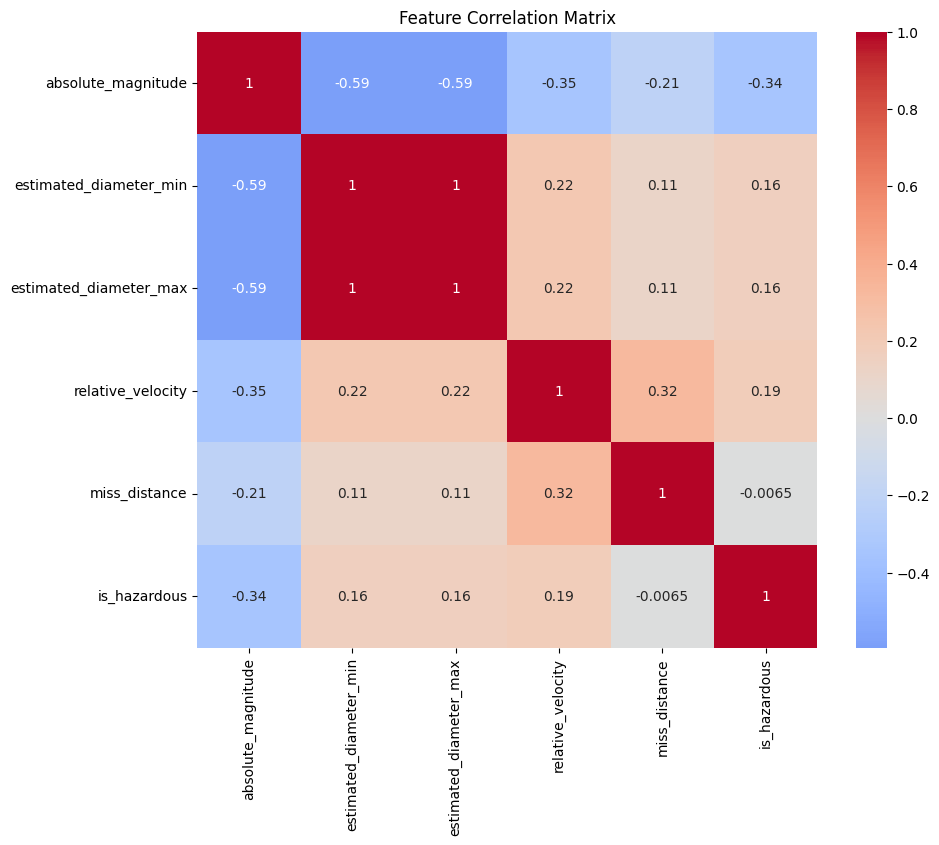

In [4]:
# Load the data
data = pd.read_csv('nearest-earth-objects(1910-2024).csv')

# Select relevant features
features = ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 
            'relative_velocity', 'miss_distance', 'is_hazardous']
df = data[features]

# Calculate covariance matrix
cov_matrix = df.cov()
print("Covariance Matrix:")
print(cov_matrix)

# Visualize covariance
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Covariance Matrix')
plt.show()

# Calculate correlation matrix
corr_matrix = df.corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

# Visualize correlation
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

###  Output Analysis of the Covariance Matrix

The **covariance matrix** shows how much two features change together.

- **Positive value**: Features tend to increase or decrease together in unison.
- **Negative value**: One feature decreases while the other increases (and vice versa).
- **Near zero**: No linear relationship between features.

####  Key Observations:
- **`absolute_magnitude` vs. `estimated_diameter_min`**  
  - **Covariance** = *-0.543*  
  - Interpretation: When diameter increases, brightness (absolute magnitude) tends to decrease — indicating a **negative relationship**.

- **`miss_distance` vs. `relative_velocity`**  
  - **Covariance** = *1.769e+11*  
  - Interpretation: These features vary **a lot together**, but due to different units (km vs. km/h), the scale is hard to interpret meaningfully.

---

###  Output Analysis of the Correlation Matrix

The **correlation matrix** also measures how two features change together, but since it's a **standardized covariance**, values range from **-1 to 1**, making interpretation easier:

- **1**: Perfect positive relationship (increase/decrease together).
- **-1**: Perfect negative relationship (one increases while the other decreases).
- **0**: No linear relationship.

####  Key Observations:
- **`absolute_magnitude` vs. `estimated_diameter_min`**  
  - **Correlation** = *-0.59*  
  - Interpretation: Moderately strong **negative relationship** — **brighter asteroids** (with lower magnitude) tend to be **smaller**.

- **`estimated_diameter_min` vs. `estimated_diameter_max`**  
  - **Correlation** = *1*  
  - Interpretation: Perfect **positive relationship** — they are practically the **same feature** or derived from each other.

- **`is_hazardous` vs. `miss_distance`**  
  - **Correlation** = *-0.0065*  
  - Interpretation: Almost **no relationship** — hazard status doesn't significantly depend on how far the asteroid misses Earth.

---

###  Summary of Covariance and Correlation Analysis:

1. **Brightness (`absolute_magnitude`) is negatively correlated with size (`diameter`)**.
2. **Hazardous status is not related to miss distance**.
3. **`estimated_diameter_min` and `estimated_diameter_max` are redundant** (highly correlated).